# 라이브러리 불러오기

In [1]:
# ! pip install -U imbalanced-learn scikit-learn
# !pip install gensim
# ! pip install optuna

In [42]:
import numpy as np
import pandas as pd
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
import matplotlib.pyplot as plt

from gensim.models import FastText
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TreebankWordTokenizer # 표준 토큰화
from nltk.corpus import stopwords # 불용어 제거
from nltk.stem import WordNetLemmatizer # 기본 형태로 변환
from imblearn.over_sampling import SMOTE # 비대칭이라 사용

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.initializers import Constant
import optuna
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/sample_submission.csv')

In [4]:
display(train_df.head())
display(test_df.head())

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [5]:
train_df.groupby('first_party_winner').size()

first_party_winner
0     829
1    1649
dtype: int64

# 데이터 전처리

## 단어 처리

In [6]:
# 문자 처리
cat_cols = ['first_party', 'second_party', 'facts']

# \b : 단어 경계, W* : 길이가 0이상이고 단어가 아닌 문자, w{1} : 길이가 1인 단어
short_word = re.compile(r'\W*\b\w{1}\b') # 길이가 1인 단어 찾기
tokenizer = TreebankWordTokenizer() # 단어 단위로 토큰화
stopword = stopwords.words('english') # 불용어 리스트 가져오기
lemmatizer = WordNetLemmatizer() # 단어의 기본 형태 가져오기

In [7]:
def prepro1(df):
        df = df.strip() # 공백 제거
        df = df.lower() # 소문자로 변경
        df = df.replace(',', '')
        df = df.replace('.', '')
        

        content = short_word.sub('', df) # 한 글자 단어 제거
        com = re.compile(r"[^\uAC00-\uD7A30-9a-zA-Z\s]") # 한글, 영어, 숫자 및 공백 문자를 제외한 모든 문자를 매칭
        content = com.sub('', content)
        tokens = tokenizer.tokenize(content) # 단어 토큰화
        token_lst = []

        for token in tokens:
            if token not in stopword: #불용어 제거
                token_lst.append(lemmatizer.lemmatize(token, 'n')) # 단어의 기본 형태 가져오기
        return token_lst

In [8]:
train_df['first_party'] = train_df['first_party'].apply(prepro1)
train_df['second_party'] = train_df['second_party'].apply(prepro1)
train_df['facts'] = train_df['facts'].apply(prepro1)

test_df['first_party'] = test_df['first_party'].apply(prepro1)
test_df['second_party'] = test_df['second_party'].apply(prepro1)
test_df['facts'] = test_df['facts'].apply(prepro1)

In [9]:
all_text = train_df['first_party'].tolist() + train_df['second_party'].tolist() + train_df['facts'].tolist()

In [10]:
train_word_counts = train_df['facts'].apply(lambda x : len(str(x).split()))

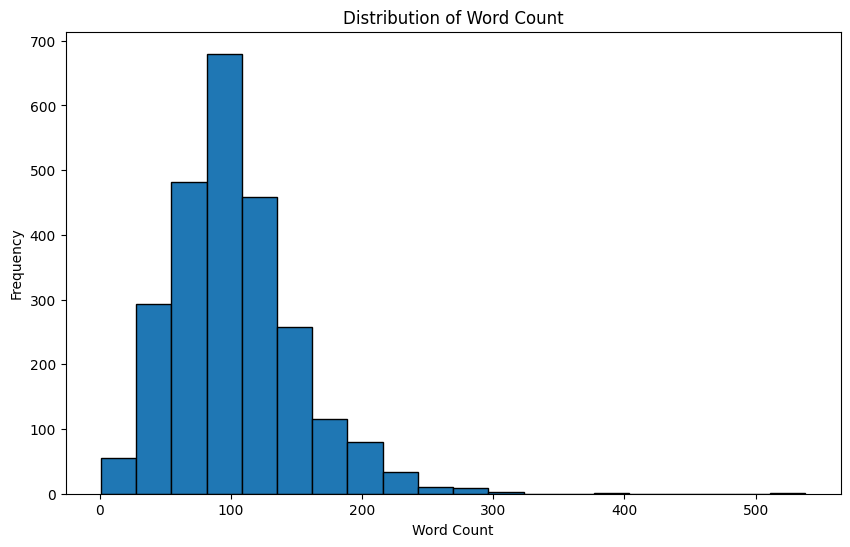

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(train_word_counts, bins=20, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.show()

## fasttext

'FastText'를 사용해 사전 훈련된 단어 임베딩을 가져오고, 이를 사용해 keras의 임베딩 레이어를 초기화한다

=> FastText 모델에서 얻은 단어 임베딩을 임베딩 행렬로 저장하고 있습니다. 이러한 저장된 임베딩 행렬은 후에 모델을 구축할 때 사용

In [12]:
model = FastText(all_text, vector_size = 100, window = 5, min_count = 1, workers = 4, sg = 1)

# tokenizer를 사용해 단어 인덱스를 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
word_index = tokenizer.word_index

In [13]:
embedding_dim = 100

In [14]:
# embedding matrix

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) # 단어 수 X 임베딩 차원

for word, i in word_index.items():
    if word in model.wv:
        embedding_vec = model.wv[word]
        embedding_matrix[i] = embedding_vec

In [15]:
# embeddings_initializer : 임베딩 레이어의 가중치를 초기화
# trainable = Fasle : 사전 훈련된 임베딩을 고정
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, embeddings_initializer = Constant(embedding_matrix), trainable = False)

In [16]:
def get_vec(model, texts):
    vects = []
    
    for text in texts:
        text_vects = []
        for word in text:
            if word in model.wv.key_to_index:
                text_vects.append(model.wv.get_vector(word))
        if len(text_vects) > 0:
            text_vects = np.mean(text_vects, axis = 0)
            vects.append(text_vects)
        else:
            vects.append(np.zeros(model.vector_size))
    
    return np.array(vects)

In [17]:
X_train_first = get_vec(model, train_df['first_party'])
X_train_second = get_vec(model, train_df['second_party'])
X_train_facts = get_vec(model, train_df['facts'])

X_train = np.concatenate([X_train_first, X_train_second, X_train_facts], axis = 1)
y_train = train_df['first_party_winner']

In [18]:
X_test_first = get_vec(model, test_df['first_party'])
X_test_second = get_vec(model, test_df['second_party'])
X_test_facts = get_vec(model, test_df['facts'])

X_test = np.concatenate([X_test_first, X_test_second, X_test_facts], axis = 1)

## 불균형 데이터 처리

In [19]:
X_smote, y_smote = smote = SMOTE(k_neighbors=5).fit_resample(X_train, y_train)
print('train shape : {}, {}'.format(X_smote.shape, y_smote.shape))

train shape : (3298, 300), (3298,)


In [20]:
y_smote.value_counts()

first_party_winner
1    1649
0    1649
Name: count, dtype: int64

## train데이터 셋으로 train, val 데이터 셋으로 분리

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, random_state = 123, test_size = 0.2)

print('Train shape : {}, {}'.format(X_train.shape, y_train.shape))
print(y_train.value_counts())

print()

print('Validation shape : {}, {}'.format(X_val.shape, y_val.shape))
print(y_val.value_counts())

Train shape : (2638, 300), (2638,)
first_party_winner
1    1328
0    1310
Name: count, dtype: int64

Validation shape : (660, 300), (660,)
first_party_winner
0    339
1    321
Name: count, dtype: int64


LSTM 모델은 일반적으로 시퀀스 데이터를 처리하기 위해 사용

첫 번째 축은 시간(또는 순서)을 나타내며, 두 번째 축은 각 시간 단계에서의 특성

In [24]:
# 차원 변경

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [25]:
X_train

array([[[ 0.31194837,  0.27364239,  0.01110053, ..., -0.19925521,
          0.25968043, -0.122569  ]],

       [[ 0.23376292,  0.2848382 ,  0.01916013, ..., -0.20334661,
          0.15123178, -0.1463282 ]],

       [[ 0.11905758,  0.273076  , -0.01880432, ..., -0.21249157,
          0.20033471, -0.13789837]],

       ...,

       [[ 0.01327598,  0.41555178, -0.03674068, ..., -0.1776814 ,
          0.1682438 , -0.17887962]],

       [[ 0.11745941,  0.28852636, -0.00296483, ..., -0.22657515,
          0.23252626, -0.03372931]],

       [[ 0.08467024,  0.42117086,  0.02608128, ..., -0.1753509 ,
          0.21896413, -0.12593327]]])

# 모델링

In [31]:
# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행하기 위한 것

def objective(trial):
    units = trial.suggest_int('units', 32, 64, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer = Adam(learning_rate = learning_rate)
    
    model = Sequential()
    model.add(LSTM(units, return_sequences = True, input_shape = (1, X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 50, verbose = 1)]
    model.fit(X_train, y_train, epochs = 100, batch_size = batch_size, validation_data = (X_val, y_val), verbose = 0, callbacks = callbacks)
    accuracy = model.evaluate(X_val, y_val, verbose = 0)[1]
    
    return accuracy

In [32]:
# objective 함수는 Optuna의 suggest_ 메서드를 사용하여 하이퍼파라미터 공간에서 샘플링하는 함수
study = optuna.create_study(direction = 'maximize')
# study 객체를 생성한 후 optimize 메서드를 사용하여 주어진 목적 함수(objective)를 최대화하는 방향으로 하이퍼파라미터를 조정
study.optimize(objective, n_trials = 50)

# Print the best hyperparameters and objective value
best_params = study.best_params
best_value = study.best_value
print("Best Parameters : ", best_params)
print("Best Value : ", best_value)

[I 2024-03-18 11:28:10,644] A new study created in memory with name: no-name-0d58b2a3-23dc-4780-abc5-9a62b6dcb7a6
[I 2024-03-18 11:28:54,500] Trial 0 finished with value: 0.5833333134651184 and parameters: {'units': 32, 'learning_rate': 4.600128515123686e-05, 'dropout_rate': 0.040045945358384794, 'batch_size': 16}. Best is trial 0 with value: 0.5833333134651184.
[I 2024-03-18 11:29:10,569] Trial 1 finished with value: 0.6257575750350952 and parameters: {'units': 32, 'learning_rate': 0.00041162167490068247, 'dropout_rate': 0.14996944879651364, 'batch_size': 64}. Best is trial 1 with value: 0.6257575750350952.
[I 2024-03-18 11:29:35,041] Trial 2 finished with value: 0.6378787755966187 and parameters: {'units': 32, 'learning_rate': 0.002032216360680544, 'dropout_rate': 0.42937422792627433, 'batch_size': 32}. Best is trial 2 with value: 0.6378787755966187.
[I 2024-03-18 11:30:16,967] Trial 3 finished with value: 0.6227272748947144 and parameters: {'units': 32, 'learning_rate': 0.0002278393

Epoch 52: early stopping


[I 2024-03-18 11:32:26,215] Trial 7 finished with value: 0.48636364936828613 and parameters: {'units': 32, 'learning_rate': 0.018611318286525562, 'dropout_rate': 0.1362405604693666, 'batch_size': 16}. Best is trial 5 with value: 0.6833333373069763.
[I 2024-03-18 11:33:10,013] Trial 8 finished with value: 0.6742424368858337 and parameters: {'units': 32, 'learning_rate': 0.001111448418071236, 'dropout_rate': 0.260967936954699, 'batch_size': 16}. Best is trial 5 with value: 0.6833333373069763.
[I 2024-03-18 11:33:36,204] Trial 9 finished with value: 0.5757575631141663 and parameters: {'units': 32, 'learning_rate': 5.08728587226915e-05, 'dropout_rate': 0.25732979139770185, 'batch_size': 32}. Best is trial 5 with value: 0.6833333373069763.
[I 2024-03-18 11:34:03,623] Trial 10 finished with value: 0.5136363506317139 and parameters: {'units': 32, 'learning_rate': 0.07768987594279271, 'dropout_rate': 0.48634273125324423, 'batch_size': 32}. Best is trial 5 with value: 0.6833333373069763.
[I 202

Epoch 54: early stopping


[I 2024-03-18 11:41:00,610] Trial 27 finished with value: 0.5136363506317139 and parameters: {'units': 32, 'learning_rate': 0.03887198090089157, 'dropout_rate': 0.121955336640932, 'batch_size': 64}. Best is trial 19 with value: 0.6924242377281189.
[I 2024-03-18 11:41:19,092] Trial 28 finished with value: 0.6227272748947144 and parameters: {'units': 32, 'learning_rate': 0.010672143385442633, 'dropout_rate': 0.05127035119531521, 'batch_size': 64}. Best is trial 19 with value: 0.6924242377281189.
[I 2024-03-18 11:41:45,462] Trial 29 finished with value: 0.592424213886261 and parameters: {'units': 32, 'learning_rate': 0.00010479022329154741, 'dropout_rate': 0.0017455221774873991, 'batch_size': 32}. Best is trial 19 with value: 0.6924242377281189.
[I 2024-03-18 11:42:03,438] Trial 30 finished with value: 0.6727272868156433 and parameters: {'units': 32, 'learning_rate': 0.003187927721221415, 'dropout_rate': 0.057720262382513474, 'batch_size': 64}. Best is trial 19 with value: 0.6924242377281

Epoch 95: early stopping


[I 2024-03-18 11:45:21,610] Trial 38 finished with value: 0.6863636374473572 and parameters: {'units': 32, 'learning_rate': 0.0020963202520388182, 'dropout_rate': 0.03506186745989193, 'batch_size': 32}. Best is trial 19 with value: 0.6924242377281189.


Epoch 92: early stopping


[I 2024-03-18 11:45:44,141] Trial 39 finished with value: 0.678787887096405 and parameters: {'units': 32, 'learning_rate': 0.0025609002471384465, 'dropout_rate': 0.025878192488303628, 'batch_size': 32}. Best is trial 19 with value: 0.6924242377281189.


Epoch 99: early stopping


[I 2024-03-18 11:46:09,009] Trial 40 finished with value: 0.592424213886261 and parameters: {'units': 32, 'learning_rate': 0.010090980543854109, 'dropout_rate': 0.08444474245931308, 'batch_size': 32}. Best is trial 19 with value: 0.6924242377281189.
[I 2024-03-18 11:46:32,876] Trial 41 finished with value: 0.6848484873771667 and parameters: {'units': 32, 'learning_rate': 0.0016029300756219957, 'dropout_rate': 0.033944850896314716, 'batch_size': 32}. Best is trial 19 with value: 0.6924242377281189.
[I 2024-03-18 11:46:56,853] Trial 42 finished with value: 0.710606038570404 and parameters: {'units': 32, 'learning_rate': 0.0011297879237680635, 'dropout_rate': 0.0300079121821481, 'batch_size': 32}. Best is trial 42 with value: 0.710606038570404.
[I 2024-03-18 11:47:20,642] Trial 43 finished with value: 0.6833333373069763 and parameters: {'units': 32, 'learning_rate': 0.00094572909977453, 'dropout_rate': 0.11922203080682127, 'batch_size': 32}. Best is trial 42 with value: 0.710606038570404.

Epoch 100: early stopping


[I 2024-03-18 11:48:08,378] Trial 45 finished with value: 0.6818181872367859 and parameters: {'units': 32, 'learning_rate': 0.0027666081933013847, 'dropout_rate': 0.031046582130790614, 'batch_size': 32}. Best is trial 42 with value: 0.710606038570404.
[I 2024-03-18 11:48:32,224] Trial 46 finished with value: 0.5469697117805481 and parameters: {'units': 32, 'learning_rate': 1.7000822430498724e-05, 'dropout_rate': 0.09563540046571706, 'batch_size': 32}. Best is trial 42 with value: 0.710606038570404.
[I 2024-03-18 11:48:56,166] Trial 47 finished with value: 0.6469696760177612 and parameters: {'units': 32, 'learning_rate': 0.0004832454852382858, 'dropout_rate': 0.05145803752230753, 'batch_size': 32}. Best is trial 42 with value: 0.710606038570404.
[I 2024-03-18 11:49:19,822] Trial 48 finished with value: 0.6409090757369995 and parameters: {'units': 32, 'learning_rate': 0.00024350369225757264, 'dropout_rate': 0.016212398407026304, 'batch_size': 32}. Best is trial 42 with value: 0.710606038

Best Parameters :  {'units': 32, 'learning_rate': 0.0011297879237680635, 'dropout_rate': 0.0300079121821481, 'batch_size': 32}
Best Value :  0.710606038570404


In [33]:
model = Sequential()
model.add(LSTM(best_params['units'], return_sequences = True, input_shape = (1, X_train.shape[2])))
model.add(Dropout(best_params['dropout_rate']))
model.add(LSTM(best_params['units']))
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 50, verbose = 1)]

model.fit(X_train, y_train, epochs = 100, batch_size = best_params['batch_size'], validation_data = (X_val, y_val), callbacks = callbacks)

vector_size = X_train.shape[2]
X_test = X_test.reshape((X_test.shape[0], 1, vector_size))

pred = model.predict(X_test)



fpr, tpr, thresholds = roc_curve(y_val, model.predict(X_val).ravel())
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
print('Best Thresholds : {}'.format(thresholds[ix]))


Epoch 1/100
83/83 [==============================] - 4s 11ms/step - loss: 0.6928 - accuracy: 0.5121 - val_loss: 0.6931 - val_accuracy: 0.4864
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5322 - val_loss: 0.6834 - val_accuracy: 0.5409
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5625 - val_loss: 0.6859 - val_accuracy: 0.5333
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5428 - val_loss: 0.6789 - val_accuracy: 0.5409
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5379 - val_loss: 0.6777 - val_accuracy: 0.5561
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5667 - val_loss: 0.6745 - val_accuracy: 0.5621
Epoch 7/100
83/83 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5705 - val_loss: 0.6719 - val_accuracy: 0.5697
Epoch 8/100

21/21 [==============================] - 0s 1ms/step


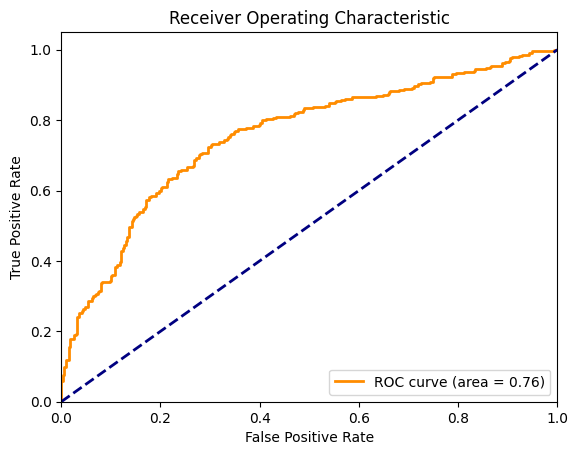

In [34]:
fpr, tpr, _ = roc_curve(y_val, model.predict(X_val).ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


In [40]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

21/21 [==============================] - 0s 1ms/step


In [44]:
y_train_pred = (y_train_pred > 0.5).astype(int)
y_val_pred = (y_val_pred > 0.5).astype(int)

In [46]:
print('train accuracy : ', accuracy_score(y_train, y_train_pred))
print('validation accuracy : ', accuracy_score(y_val, y_val_pred))

train accuracy :  0.8225928733889311
validation accuracy :  0.7106060606060606


# 제출

In [47]:
y_pred = (pred > thresholds[ix]).astype(int).flatten()
submission_df['first_party_winner'] = y_pred
submission_df.to_csv('fasttext_smote_lstm.csv', index = False)